## Geospatial Data Scientist Census Activity
**Author:** Nicole Pepper

**Date:** 11/21/2025

**GitHub Repo:** https://github.com/nicolelpepper/af-census-activity

### 1) Set Up Workspace

In [1]:
# ---- Load libraries ----
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import re
from rasterio.mask import mask
from rasterstats import zonal_stats
from rasterio.plot import show
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)



### 2) Load Project Data

In [2]:
# ---- Read in project data ----

# american community survey data
acs = pd.read_csv("data/raw/ACSDP5Y2023.DP05_2025-11-17T173744/ACSDP5Y2023.DP05-Data.csv")

# landcover data
landcover = rasterio.open("data/raw/landcover/landcover_conus.tif")

# schools data
private_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PRIVATESCH_2122/EDGE_GEOCODE_PRIVATESCH_2122.shp").to_crs(landcover.crs)
public_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PUBLICSCH_2324/EDGE_GEOCODE_PUBLICSCH_2324.shp").to_crs(landcover.crs)

# census tracts data for 2025 (choose a state)
florida_tracts = gpd.read_file("data/raw/tracts/12/tl_2025_12_tract.shp").to_crs(landcover.crs)
# oregon_tracts = gpd.read_file("data/raw/tracts/41/tl_2025_41_tract.shp")
# pennsylvania_tracts = gpd.read_file("data/raw/tracts/42/tl_2025_42_tract.shp")

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_60196/3388459933.py:4: DtypeWarning: Columns (2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,58,59,60,61,62,63,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,238,246,254,324,338,372) have mixed types. Specify dtype option on import or set low_memory=False.
  acs = pd.read_csv("data/raw/ACSDP5Y2023.DP05_2025-11-17T173744/ACSDP5Y2023.DP05-Data.csv")


### 3) Explore & Clean Data

##### Prep American Community Survey (acs) Data

In [3]:
# --- Explore  & prep american community survey data ----

# Check column names
acs.columns

# Get snapshot of data
acs.head

# Save 1st row as metadata for columns (bc there are two header rows)
metadata_row = acs.iloc[0]
col_metadata = metadata_row.to_dict()
print(col_metadata)

# Drop extra header and reset index
acs = acs.drop(index=0).reset_index(drop=True)
acs.head

# ---- Select demographic data for Florida ----

# Select primary id fields and 2 demographic statistics of choice: 0037PE (percent white) and 0075PE (percent hispanic)
acs = acs[["GEO_ID", "NAME", "DP05_0001E","DP05_0037PE", "DP05_0075PE"]] 

# filter to Florida
fl_acs = acs[acs["GEO_ID"].str.contains("1400000US12")]

# ---- Clean errors in population statistics columns ----

# Select population statistics columns
pop_cols = ["DP05_0001E","DP05_0037PE","DP05_0075PE"]

# Force non-numeric values to NA
fl_acs[pop_cols] = fl_acs[pop_cols].apply(
    pd.to_numeric,
    errors="coerce")

fl_acs

{'GEO_ID': 'Geography', 'NAME': 'Geographic Area Name', 'DP05_0001E': 'Estimate!!SEX AND AGE!!Total population', 'DP05_0001M': 'Margin of Error!!SEX AND AGE!!Total population', 'DP05_0002E': 'Estimate!!SEX AND AGE!!Total population!!Male', 'DP05_0002M': 'Margin of Error!!SEX AND AGE!!Total population!!Male', 'DP05_0003E': 'Estimate!!SEX AND AGE!!Total population!!Female', 'DP05_0003M': 'Margin of Error!!SEX AND AGE!!Total population!!Female', 'DP05_0004E': 'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)', 'DP05_0004M': 'Margin of Error!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)', 'DP05_0005E': 'Estimate!!SEX AND AGE!!Total population!!Under 5 years', 'DP05_0005M': 'Margin of Error!!SEX AND AGE!!Total population!!Under 5 years', 'DP05_0006E': 'Estimate!!SEX AND AGE!!Total population!!5 to 9 years', 'DP05_0006M': 'Margin of Error!!SEX AND AGE!!Total population!!5 to 9 years', 'DP05_0007E': 'Estimate!!SEX AND AGE!!Total population!!10 to 

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_60196/1741720929.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_acs[pop_cols] = fl_acs[pop_cols].apply(


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Prep Schools Data

In [4]:
# ---- Explore & prep schools data -----

# Explore data
public_schools.head
private_schools.head

# Add descriptive column for schools
public_schools["school_type"] = "public_schools"
private_schools["school_type"] = "private_schools"

# Join schools data
schools = pd.concat([public_schools, private_schools], ignore_index = True)

In [5]:
schools

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [5]:
# --- Count schools in florida tracts ----

# Left join with florida tracts 
schools_in_florida = gpd.sjoin(
    florida_tracts,
    schools,
    how = "left",
    predicate = "intersects")


schools_in_florida

# Count schools per tract unique tract using GEOID
school_counts = (schools_in_florida
                 .groupby(["GEOIDFQ","school_type"])
                 .size()
                 .unstack(fill_value=0)
                 .reset_index())


In [6]:
school_counts

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Prep landcover data

In [7]:
# ---- Clip landcover data to Florida ----

# Dissolve florida tracts to get clipping boundary
fl_union = florida_tracts.unary_union

# Clip landcover to Florida
landcover_clip, landcover_transform = mask(landcover, [fl_union], crop = True)
landcover_array = landcover_clip[0]
nodata = landcover.nodata

# Check unique values in landcover (it's already filtered to only forest cover)
np.unique(landcover_array)


/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_60196/4123986077.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fl_union = florida_tracts.unary_union


array([-128,   41,   42,   43], dtype=int16)

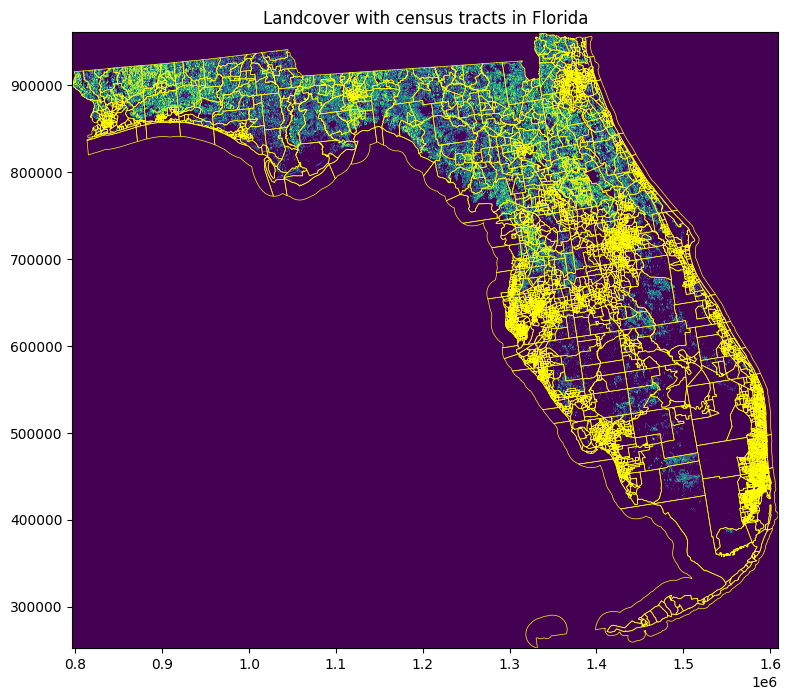

In [8]:
# ---- Check out landcover and census tracts ----
fig, ax = plt.subplots(figsize=(10, 8))

# Plot florida landcover
rasterio.plot.show(landcover_array, ax = ax, transform = landcover_transform)
# Add Florida census tracts
florida_tracts.boundary.plot(ax = ax, edgecolor = "yellow", linewidth = 0.5)

ax.set_title("Landcover with census tracts in Florida")
plt.show()

In [9]:
# ---- Zonal statistics on the clipped landcover ----
landcover_count = zonal_stats(
    florida_tracts,
    landcover_array,
    affine = landcover_transform,
    categorical = True,
    nodata = nodata)

In [10]:
# ---- Calculate total forested pixels per census tract ----

forest_pixels = []

for counts in landcover_count:
    forest_count = 0
    for landcover_class, pixel_count in counts.items():
        if landcover_class != nodata:
            forest_count += pixel_count
    forest_pixels.append(forest_count)


### 4) Merge Datasets

In [11]:
# ---- Merge acs data to florida tracts ----

# Left merge school counts on florida tracts
florida_tracts = florida_tracts.merge(
    fl_acs,
    how = "left",
    left_on = "GEOIDFQ",
    right_on = "GEO_ID")

In [12]:
# ---- Merge forest cover data ----

florida_tracts["forest_pixels"] = forest_pixels

# Calculate forested area by convert to m2 by multiplying by 900 bc 30 x 30m resolution
florida_tracts["forest_area_m2"] = (
    florida_tracts["forest_pixels"] * 900
)

# ---- Calculate statistics -----

# Calculate percent forest cover
florida_tracts["pct_forest_cover"] = (florida_tracts["forest_area_m2"]/florida_tracts["ALAND"])*100

# Calculate trees per capita
florida_tracts["trees_per_capita"] = np.where(
 
    # Avoid divison by zero
    florida_tracts["DP05_0001E"] > 0,

    # Convert 600 sqft to ms (1 sq ft = 0.092903 sq ms) 600 x 0.092903 = 55.7418
    florida_tracts["forest_area_m2"] / 55.7418 / florida_tracts["DP05_0001E"],
    np.nan
)

In [ ]:
# ---- Merge school data to florida tracts ---

# Left merge school counts on florida tracts
florida_tracts = florida_tracts.merge(
    school_counts,
    how = "left",
    on = "GEOIDFQ")


# ---- Calculate school statistics ----

# Calculate total schools per tract
florida_tracts["total_schools"] = (florida_tracts["public_schools"] + florida_tracts["private_schools"])

# Calculate schools per capita
florida_tracts["schools_per_capita"] = (florida_tracts["total_schools"]/ florida_tracts["DP05_0001E"])

# Calculate schools per capita
florida_tracts["public_school_ratio"] = (florida_tracts["public_schools"]/florida_tracts["private_schools"])


In [17]:
florida_tracts["schools_per_capita"].value_counts().head(10)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [16]:
# Fill in NAs for no schools with 0s
florida_tracts[["public_schools", "private_schools"]] = (
    florida_tracts[["public_schools", "private_schools"]].fillna(0))

In [20]:
florida_summary = florida_tracts[["GEOID",
                                  "DP05_0001E",
                                  "pct_forest_cover",
                                  "trees_per_capita",
                                  "private_schools",
                                  "public_schools",
                                  "schools_per_capita"]]

In [ ]:
florida_summary = florida_summary.rename(columns={
    "GEOID": "Census Tract ID (GEOID)",
    "DP05_0001E": "Total Population",
    "pct_forest_cover": "Percent Forest Cover",
})

florida_summary.columns = (florida_summary
                           .columns
                           .str.replace("_", " ")
                           .str.title())

florida_summary[["Percent Forest Cover", "Trees Per Capita"]] = (
    florida_summary[["Percent Forest Cover", "Trees Per Capita"]].round(2))


In [31]:
florida_summary

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [19]:
show(florida_summary,
    scrollY="400px")

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [20]:
print(florida_tracts["schools_per_capita"].dtype)
print

float64


<function print>